In [6]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import pyart

In [7]:
def rca_calculation(filename):
    '''Calculates the 95th percentile clutter area reflectivity and RCA using baseline and clutter map'''
    from netCDF4 import Dataset
    dataset = Dataset('/home/hunzinger/data/rca_baseline_20181102.nc')
    PCT_on_50 = dataset.variables['Flagged clutter grid gates'][:,:]
    vPCT_on_50 = dataset.variables['Flagged clutter grid gates (V)'][:,:]
    dbz95_baseline = dataset.variables['Baseline 95th reflectivity'][:]
    vdbz95_baseline = dataset.variables['Baseline 95th reflectivity (V)'][:]
    dataset.close()
    
    radar = pyart.aux_io.read_gamic(filename, file_field_names=True) 
    #radar = pyart.io.cfradial.read_cfradial(filename)
    date_time = radar.time['units'].replace('seconds since ', '')
    
    # Constrain range between 1 - 5 km
    r_start_idx = np.where(radar.range['data'] < 1000.)[0][-1]+1
    r_start_idx = 0
    r_stop_idx = np.where(radar.range['data'] > 10000.)[0][0]
    
    # Using lowest elevation angle of PPI (0.5 deg)
    sweep_start_idx = radar.sweep_start_ray_index['data'][0]
    sweep_stop_idx = radar.sweep_end_ray_index['data'][0]+1
    
    # Get variables (only the rays/gates needed)
    #zh = radar.fields['reflectivity']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    zh = radar.fields['Zh']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    zv = radar.fields['Zv']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    r = radar.range['data'][r_start_idx:r_stop_idx]
    theta = radar.azimuth['data'][sweep_start_idx:sweep_stop_idx]
    
    # Eliminate duplicate azimuths to maintain a total # of azimuths of 360
    if len(theta) > 360:
        diff = len(theta) - 360
        zh = np.delete(zh,-diff,axis=0)
        zv = np.delete(zv,-diff,axis=0)
        theta = np.delete(theta,-diff)
        
    # Arrange/sort azimuths to span 0 to 360 deg. from index 0 to 359
    sorted_idx = np.argsort(theta)
    zh = zh[sorted_idx,:]
    zv = zv[sorted_idx]
    theta = theta[sorted_idx]
    
    # Create array to store qualifying reflectivities (fall within PCT_on > 0.5)
    zh_car = np.empty((zh.shape))
    zh_car[:,:] = np.nan
    zv_car = np.empty((zv.shape))
    zv_car[:,:] = np.nan
    
    # Find and store all reflectivity values that fall within the PCT_on > 0.5 grid gate
    for i in range(0,len(PCT_on_50[:,0])):
        for j in range(0,len(PCT_on_50[0,:])):
            if np.isfinite(PCT_on_50[i,j]):
                zh_car[i,j*10-10:j*10] = zh[i,j*10-10:j*10]
                
    # Calculate the PDF of the clutter area reflectivity (CAR)
    mask = np.where(np.isfinite(zh_car))  
    n,bins,patches=plt.hist(zh_car[mask],bins=105,range=(-40.,65.))
    
    # Calculate CDF of clutter area reflectivity
    cdf = np.cumsum(n)
    p = cdf/cdf[-1]*100
    
    # Find coefficients of 13th degree polynomial for CDF
    x = np.arange(105)-40
    coeff = np.polyfit(p,x,13)
    poly_func = np.poly1d(coeff)
    #x_poly = np.linspace(p[0],p[-1],105)
    #y_poly = poly_func(x_poly)
    
    # Find the value of reflectivity at the 95th percentile of CDF
    dbz95 = poly_func(95.)
    
    # Calculate RCA
    rca = dbz95_baseline - dbz95
    
    # V POLARIZATION
    # Find and store all reflectivity values that fall within the PCT_on > 0.5 grid gate
    for i in range(0,len(vPCT_on_50[:,0])):
        for j in range(0,len(vPCT_on_50[0,:])):
            if np.isfinite(vPCT_on_50[i,j]):
                zv_car[i,j*10-10:j*10] = zv[i,j*10-10:j*10]
                
    # Calculate the PDF of the clutter area reflectivity (CAR)
    mask = np.where(np.isfinite(zv_car))  
    vn,vbins,vpatches=plt.hist(zv_car[mask],bins=525,range=(-40.,65.))
    
    # Calculate CDF of clutter area reflectivity
    cdf = np.cumsum(vn)
    vp = cdf/cdf[-1]*100
    
    # Find coefficients of 13th degree polynomial for CDF
    x = np.arange(525)*(1/5)-40
    coeff = np.polyfit(vp,x,13)
    poly_func = np.poly1d(coeff)
    #x_poly = np.linspace(p[0],p[-1],105)
    #y_poly = poly_func(x_poly)
    
    # Find the value of reflectivity at the 95th percentile of CDF
    dbz95_v = poly_func(95.)
    
    # Calculate RCA
    vrca = vdbz95_baseline - dbz95_v
    
    del radar
    return date_time, zh_car, n, bins, p, dbz95, dbz95_baseline, rca, zv_car, vn, vbins, vp, dbz95_v, vdbz95_baseline, vrca

/home/hunzinger/data/ppi/corcsaprM1.00.20181108.231001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108214503_00.h5
/home/hunzinger/data/ppi/corcsaprM1.00.20181108.151001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108140003_00.h5
/home/hunzinger/data/ppi/corcsaprM1.00.20181108.221001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108210003_00.h5
/home/hunzinger/data/ppi/corcsaprM1.00.20181108.111001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108093003_00.h5
/home/hunzinger/data/ppi/corcsaprM1.00.20181108.011001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181107234503_00.h5
/home/hunzinger/data/ppi/corcsaprM1.00.20181108.101001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108084503_00.h5
/home/hunzinger/data/ppi/corcsaprM1.00.20181108.161001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108143008_00.h5
/home/hunzinger/data/ppi/corcsaprM1.00.20181108.071001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108060004_00.h5
/home/hunzinger/data/ppi/corcsaprM1.00.20181108.091001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108073003_00.h5
/home/hunzinger/data/ppi/cor

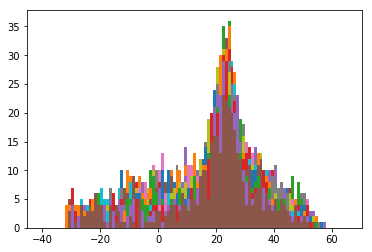

In [8]:
# Run this function on a bunch of files (try data from one day)
import os
import glob

dt = []
zh = []
n = []
bins = []
cdf = []
p = []
dbz95 = []
dbz95_baseline = []
rca = []
zv = []
vn = []
vbins = []
vp = []
vdbz95 = []
vdbz95_baseline = []
vrca = []

for f in glob.glob(os.path.join('/home/hunzinger/data/ppi/', 'corcsaprM1*.20181108.*cor-ppi*.h5')):
    print(f)
    DateTime, ZH, N, Bins, P, DBZ95, DBZ95BASE, RCA, ZV, VN, VBins, VP, VDBZ95, VDBZ95BASE, VRCA = rca_calculate_netcdf(f)
    
    # Put all PPI times into a list
    dt.append(DateTime)
    zh.append(ZH)
    n.append(N)
    bins.append(Bins)
    p.append(P)
    dbz95.append(DBZ95)
    dbz95_baseline.append(DBZ95BASE)
    rca.append(RCA)
    zv.append(ZV)
    vn.append(VN)
    vbins.append(VBins)
    vp.append(VP)
    vdbz95.append(VDBZ95)
    vdbz95_baseline.append(VDBZ95BASE)
    vrca.append(VRCA)

In [3]:
dbz95_min = np.nanmin(dbz95)
dbz95_max = np.nanmax(dbz95)
#dbz95_std = np.nanstd(dbz95)
dbz95_mean = np.nanmean(dbz95)

rca_min = np.nanmin(rca)
rca_max = np.nanmax(rca)
#rca_std = np.nanstd(rca)
rca_mean = np.nanmean(rca)
rca_mean = dbz95_baseline[0][0] - dbz95_mean

vdbz95_min = np.nanmin(vdbz95)
vdbz95_max = np.nanmax(vdbz95)
#vdbz95_std = np.nanstd(vdbz95)
vdbz95_mean = np.nanmean(vdbz95)

vrca_min = np.nanmin(vrca)
vrca_max = np.nanmax(vrca)
#vrca_std = np.nanstd(vrca)
vrca_mean = np.nanmean(vrca)
vrca_mean = vdbz95_baseline[0][0] - vdbz95_mean

date = dt[0][0:10]
base = 1

d = {'Date':[date],'RCA':[rca_mean],'RCA_V':[vrca_mean],'Baseline':[base]}
dff = pd.DataFrame(data=d)

NameError: name 'dbz95' is not defined

In [19]:
#import csv
#with open('/home/hunzinger/data/rca_daily_values.csv', mode='w') as rca_file:
#    fieldnames = ['Date', 'RCA', 'Baseline']
#    writer = csv.DictWriter(rca_file, fieldnames=fieldnames)

#    writer.writeheader()
#    writer.writerow({'Date': date, 'RCA': rca_mean, 'Baseline': 1})
    
#with open('/home/hunzinger/data/rca_daily_values.csv', mode='a') as rca_file:
#    writer = csv.writer(rca_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

#    writer.writerow([date, rca_mean, 1])


In [4]:
print(dff)

NameError: name 'dff' is not defined

In [5]:
filename = '/home/hunzinger/data/rca_daily_values.csv'
with open(filename, 'a') as f:
    dff.to_csv(f, mode='a', header=f.tell()==0)

NameError: name 'dff' is not defined

In [ ]:
dat = pandas.read_csv('/home/hunzinger/data/rca_daily_values.csv')
print(dat)